In [1]:
from cgeniepy.ecology import EcoModel
import xarray as xr
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cmap import Colormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

arctic_mask = xr.load_dataarray("../data/masked_array.nc")

# Load all 4 models
model_main = EcoModel("../model/muffin.u067bc.PO4Fe.main/", gemflag=['biogem', 'ecogem'])
model_test0 = EcoModel("../model/muffin.u067bc.PO4Fe.test0/", gemflag=['biogem', 'ecogem'])
model_test1 = EcoModel("../model/muffin.u067bc.PO4Fe.test1/", gemflag=['biogem', 'ecogem'])
model_test2 = EcoModel("../model/muffin.u067bc.PO4Fe.test2/", gemflag=['biogem', 'ecogem'])

# Store models in a list for easier processing
models = [model_main, model_test0, model_test1, model_test2]

# Get time steps (assuming all models have the same time structure)
time_steps = model_main.get_pft(1).data.time

## recalculate because foram use a different method
qcarbon_a = model_main.get_config('ECOGEM')['qcarbon_a']
qcarbon_b = model_main.get_config('ECOGEM')['qcarbon_b']
volume = model_main.eco_pars()['volume']
carbon_thresholds = qcarbon_a * volume ** qcarbon_b

## counting from 0
phyto_index = np.arange(0,32)
zoo_index = np.arange(32,64)
mixo_index = np.arange(64,96)
foram_index = np.arange(96,112)
all_index = [i for i in range(1,113)]

print("carbon_thresholds", carbon_thresholds)

def calculate_diversity_for_model(model):
    """Calculate diversity metrics for a single model"""
    model_mask = model.grid_mask()
    extinction = np.ones(len(carbon_thresholds))  ## 1 means extinct
    
    phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []
    
    for i in range(len(carbon_thresholds)):
        pft = model.get_pft(i+1)
        threshold = carbon_thresholds[i]    
        ## filter out the species with biomass less than threshold    
        pft_presence = xr.where(pft > threshold, 1, 0.0)
        
        if i in phyto_index:
            phyto_rich.append(pft_presence)
        elif i in zoo_index:
            zoo_rich.append(pft_presence)
        elif i in mixo_index:
            mixo_rich.append(pft_presence)
        elif i in foram_index:
            foram_rich.append(pft_presence)
    
        if pft_presence[-1].sum() > 0:
            extinction[i] = 0
    
    ## sum over PFT dimension
    phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask * arctic_mask
    zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask * arctic_mask
    mixo_rich = xr.concat(mixo_rich, dim='pft') * model_mask * arctic_mask
    foram_rich = xr.concat(foram_rich, dim='pft') * model_mask * arctic_mask
    total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') + mixo_rich.sum(dim='pft') + foram_rich.sum(dim='pft')
    
    total_pft = total_pft * model_mask * arctic_mask
    total_pft = GriddedData(total_pft, attrs={'long_name': 'No. PFTs', 'units': ''})
    survivor_rate = (total_pft / total_pft[0]) * 100
    survivor_rate.attrs['long_name'] = 'percentage'
    
    ## plot survivors' traits
    trait_df = model.eco_pars().copy()
    trait_df['extinction'] = extinction            
    survivor_df = trait_df[trait_df['extinction'] == 0]
    trait_df['q_C'] = qcarbon_a * trait_df['volume'] ** qcarbon_b
    
    return total_pft, survivor_rate, trait_df, survivor_df

# Calculate diversity for all models
results = []
for model in models:
    total_pft, survivor_rate, trait_df, survivor_df = calculate_diversity_for_model(model)
    results.append((total_pft, survivor_rate, trait_df, survivor_df))

Error registering colormaps: could not convert string to float: 'purple4'
carbon_thresholds 0      1.880960e-14
1      5.490153e-14
2      1.171970e-13
3      2.111499e-13
4      3.409422e-13
           ...     
107    1.659541e-05
108    3.669901e-05
109    8.104507e-05
110    1.962074e-04
111    4.787931e-04
Name: volume, Length: 112, dtype: float64


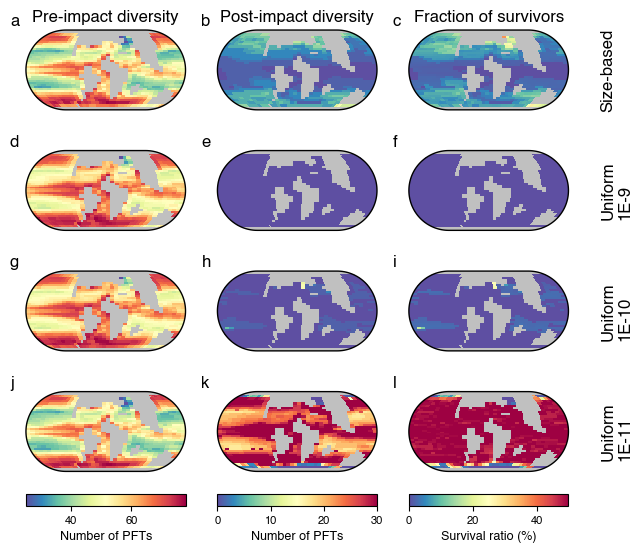

In [2]:
# Create the plot with 4 models x 3 panels = 12 subplots
fig, axs = plt.subplots(4, 3, subplot_kw={'projection': ccrs.EckertIV()}, figsize=(7, 6))

## set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

cmap = "Spectral_r"
model_names = ['Size-based', 'Uniform\n1E-9',
               'Uniform\n1E-10', 'Uniform\n1E-11']

# Store the mappable objects for colorbars
im_list = [None, None, None]  # For each column

# Plot each model
for i, (model_name, (total_pft, survivor_rate, trait_df, survivor_df)) in enumerate(zip(model_names, results)):    
    # Pre-impact diversity
    ip1 = total_pft.isel(time=1).to_GriddedDataVis()
    ip1.aes_dict['facecolor_kwargs']['c'] = 'silver'
    im1 = ip1.plot(ax=axs[i, 0], cmap=cmap, add_colorbar=False, 
                                     transform=ccrs.PlateCarree())
    if i == 0:
        axs[i, 0].set_title('Pre-impact diversity')
        im_list[0] = im1  # Store for colorbar
    
    # Post-impact diversity
    ip2 = total_pft.isel(time=-1).to_GriddedDataVis()
    ip2.aes_dict['facecolor_kwargs']['c'] = 'silver'
    im2 = ip2.plot(ax=axs[i, 1], cmap=cmap, add_colorbar=False, 
                                      vmax=30, transform=ccrs.PlateCarree())

    if i == 0:
        axs[i, 1].set_title('Post-impact diversity')
        im_list[1] = im2  # Store for colorbar
    
    # Fraction of survivors
    ip3 = survivor_rate.isel(time=-1).to_GriddedDataVis()
    ip3.aes_dict['facecolor_kwargs']['c'] = 'silver'
    im3 = ip3.plot(ax=axs[i, 2], cmap=cmap, add_colorbar=False,
                   vmin=0, vmax=50, transform=ccrs.PlateCarree())

    if i == 0:
        axs[i, 2].set_title('Fraction of survivors')
        im_list[2] = im3  # Store for colorbar
    
    # Add model name as ylabel
    axs[i, 2].text(1.2, 0.5, model_name, transform=axs[i, 2].transAxes,
                   rotation=90, verticalalignment='center', fontsize=12, fontweight='bold')

# Add colorbars for each column
column_titles = ['Pre-impact diversity', 'Post-impact diversity', 'Fraction of survivors']
colorbar_labels = ['Number of PFTs', 'Number of PFTs', 'Survival ratio (%)']

for col in range(3):
    # Position colorbar below each column
    left = axs[0, col].get_position().x0
    width = axs[0, col].get_position().width
    cbar_ax = fig.add_axes([left, 0.07, width, 0.02])
    cbar = plt.colorbar(im_list[col], cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label(colorbar_labels[col], fontsize=9)

#add alphabetic labels
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.05, chr(97 + i), transform=ax.transAxes, fontsize=12, fontweight='bold')


fig.savefig("../output/alternative_extinction_threshold.png", dpi=300, bbox_inches='tight')